In [1]:
from pyprojroot.here import here
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv(here('data/3p/saturation_curves/manually_downsampled.csv')).dropna()
metadata = pd.read_csv(here('config/3p/metadata.csv'))
data = pd.merge(data, metadata, on=['Sample', 'Kit'])

In [3]:
data.head()

,Kit,Sample,nreads,median_genes,median_umi,File,Individual,Replicate,Sensitivity
0,Fluent_v4,Fluent_v4_F1A,1000.0,246.0,293.0,B2-FBv4_F1A,F1,A,5.0
1,Fluent_v4,Fluent_v4_F1A,2500.0,477.0,647.0,B2-FBv4_F1A,F1,A,5.0
2,Fluent_v4,Fluent_v4_F1A,5000.0,719.0,1086.0,B2-FBv4_F1A,F1,A,5.0
3,Fluent_v4,Fluent_v4_F1A,7500.0,874.0,1403.0,B2-FBv4_F1A,F1,A,5.0
4,Fluent_v4,Fluent_v4_F1A,10000.0,984.0,1642.0,B2-FBv4_F1A,F1,A,5.0


In [4]:
##define the hill equation

def hill_func(x, a, n, c): # Hill equation expanded to have a vmax that is not 1
    return  a * np.power(x, n) / (np.power(c, n) + np.power(x, n)) 

##setup dictionary to save results
modeling_dict = {}
plotting_dict = {}

##Loop through each method (replicates combined) to find optimal parameters and fitted values
for method in data['Sample'].unique():
    
    print(f"Fitting Curve for {method}")
    
    # Get X and Y for gene counts
    X = data.loc[data['Sample'] == method, 'nreads']
    Y = data.loc[data['Sample'] == method, 'median_genes']


    # Initialize parameters with values around where we expect for a, n, c
    init_vals = np.array([3000, 1.0, 10])

    # supress curve fit warnings
    # warnings.filterwarnings("ignore")

    # curve fit the test data
    popt, pcov = curve_fit(hill_func, X, Y, p0=init_vals)
    
    # get sd or parameters
    perr = np.sqrt(np.diag(pcov))
    
    #unpack parameters
    a, n, c = popt
    a_sd, n_sd, c_sd = perr

    # get predictions
    pred_vals = hill_func(X, *popt) 
    
    # get errors
    errors = pred_vals - Y

    SE = np.square(errors) # squared errors
    MSE = np.mean(SE) # mean squared errors
    RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
    Rsquared = 1.0 - (np.sum(SE) / np.sum(np.square(Y - np.mean(Y)))) # 1- RSS/TSS

    print('Parameters:', popt)
    print('RMSE:', RMSE)
    print('R-squared:', Rsquared)
    
    # get fitted values for fitted equation plot
    x_smooth = np.linspace(min(X), max(X))
    y_fitted = hill_func(x_smooth, *popt)
    
    # put together results in dataframe to add so modeling dict
    modeling_dict[method] = {'max_val': a,'hill_coefficient': n, 'RD50': c, 
                             'max_val_sd': a_sd, 'hill_sd': n_sd,'RD50_sd': c_sd,
                             'RMSE': RMSE, 'R-squared': Rsquared}
    
    # put together fitted values in df for plotting
    plotting_dict[method] = pd.DataFrame({'nreads': x_smooth, 'median_gene_counts': y_fitted})
    
    print(f"Finished modeling {method}")
    print()
    
##combine plotting dict into df
# modeling_df = pd.concat(modeling_dict, axis=0, names = ['method', 'index']).reset_index(drop=False).drop('index', axis = 1)
modeling_df = pd.DataFrame(modeling_dict).T.reset_index(names='platform')
plotting_df = pd.concat(plotting_dict, axis=0, names = ['platform', 'index']).reset_index(drop=False).drop('index', axis = 1)
del plotting_dict, modeling_dict

Fitting Curve for Fluent_v4_F1A
Parameters: [1.66862722e+03 9.19453558e-01 6.75950208e+03]
RMSE: 0.4366584570895596
R-squared: 0.9999981779315577
Finished modeling Fluent_v4_F1A

Fitting Curve for Fluent_v4_F1B
Parameters: [1.63313401e+03 9.28236457e-01 7.13299785e+03]
RMSE: 0.4458556927936693
R-squared: 0.9999980348525617
Finished modeling Fluent_v4_F1B

Fitting Curve for Fluent_v4_F5A
Parameters: [1.69500754e+03 9.24924995e-01 6.79273468e+03]
RMSE: 0.35762975687827614
R-squared: 0.9999988759444421
Finished modeling Fluent_v4_F5A

Fitting Curve for Fluent_v4_F5B
Parameters: [1.26167836e+03 9.40500568e-01 4.86301373e+03]
RMSE: 0.34699177127583025
R-squared: 0.9999980579436379
Finished modeling Fluent_v4_F5B

Fitting Curve for Fluent_V_F1A
Parameters: [1.93699840e+03 8.32735964e-01 8.84393130e+03]
RMSE: 2.193440625127985
R-squared: 0.9999584318417173
Finished modeling Fluent_V_F1A

Fitting Curve for Fluent_V_F1B
Parameters: [1.90740535e+03 8.36899327e-01 8.26481587e+03]
RMSE: 2.03639253

/loc/scratch/6698688/ipykernel_16684/3339772571.py:4: RuntimeWarning: invalid value encountered in power
  return  a * np.power(x, n) / (np.power(c, n) + np.power(x, n))
/loc/scratch/6698688/ipykernel_16684/3339772571.py:4: RuntimeWarning: invalid value encountered in power
  return  a * np.power(x, n) / (np.power(c, n) + np.power(x, n))
/loc/scratch/6698688/ipykernel_16684/3339772571.py:4: RuntimeWarning: invalid value encountered in power
  return  a * np.power(x, n) / (np.power(c, n) + np.power(x, n))
/loc/scratch/6698688/ipykernel_16684/3339772571.py:4: RuntimeWarning: invalid value encountered in power
  return  a * np.power(x, n) / (np.power(c, n) + np.power(x, n))
/loc/scratch/6698688/ipykernel_16684/3339772571.py:4: RuntimeWarning: invalid value encountered in power
  return  a * np.power(x, n) / (np.power(c, n) + np.power(x, n))
/loc/scratch/6698688/ipykernel_16684/3339772571.py:4: RuntimeWarning: invalid value encountered in power
  return  a * np.power(x, n) / (np.power(c, n

Parameters: [2.14212349e+03 8.48577886e-01 7.72835261e+03]
RMSE: 2.5484345580999372
R-squared: 0.9999565358513598
Finished modeling Fluent_V_F5B

Fitting Curve for NextGEM3P_F1A
Parameters: [3.16950641e+03 8.75946235e-01 9.92868547e+03]
RMSE: 3.808727629671601
R-squared: 0.999955434832631
Finished modeling NextGEM3P_F1A

Fitting Curve for NextGEM3P_F1B
Parameters: [2.86549590e+03 8.76545884e-01 9.06214560e+03]
RMSE: 3.640035349495724
R-squared: 0.9999498719627404
Finished modeling NextGEM3P_F1B

Fitting Curve for NextGEM3P_F5A
Parameters: [3.02365890e+03 8.79127924e-01 9.45453098e+03]
RMSE: 4.80382558357373
R-squared: 0.9999235405189226
Finished modeling NextGEM3P_F5A

Fitting Curve for NextGEM3P_F5B
Parameters: [2.94957555e+03 8.83182313e-01 8.97273029e+03]
RMSE: 4.7203834162579215
R-squared: 0.999923947736814
Finished modeling NextGEM3P_F5B

Fitting Curve for GEMX3P_F1A
Parameters: [4.60083838e+03 8.64691199e-01 1.51996545e+04]
RMSE: 2.013848780936191
R-squared: 0.9999928968759461
Fi

/loc/scratch/6698688/ipykernel_16684/3339772571.py:4: RuntimeWarning: invalid value encountered in power
  return  a * np.power(x, n) / (np.power(c, n) + np.power(x, n))
/loc/scratch/6698688/ipykernel_16684/3339772571.py:4: RuntimeWarning: invalid value encountered in power
  return  a * np.power(x, n) / (np.power(c, n) + np.power(x, n))
/loc/scratch/6698688/ipykernel_16684/3339772571.py:4: RuntimeWarning: invalid value encountered in power
  return  a * np.power(x, n) / (np.power(c, n) + np.power(x, n))
/loc/scratch/6698688/ipykernel_16684/3339772571.py:4: RuntimeWarning: invalid value encountered in power
  return  a * np.power(x, n) / (np.power(c, n) + np.power(x, n))
/loc/scratch/6698688/ipykernel_16684/3339772571.py:4: RuntimeWarning: invalid value encountered in power
  return  a * np.power(x, n) / (np.power(c, n) + np.power(x, n))
/loc/scratch/6698688/ipykernel_16684/3339772571.py:4: RuntimeWarning: invalid value encountered in power
  return  a * np.power(x, n) / (np.power(c, n

Parameters: [2.88972709e+03 9.49966882e-01 5.20085120e+03]
RMSE: 0.3570375146365878
R-squared: 0.9999996158402886
Finished modeling Scale_F5A

Fitting Curve for Scale_F1B
Parameters: [2.33003538e+03 9.68653848e-01 4.32706135e+03]
RMSE: 0.638985846600231
R-squared: 0.9999981265166157
Finished modeling Scale_F1B

Fitting Curve for Scale_F1A
Parameters: [2.52419121e+03 9.52881005e-01 6.44336494e+03]
RMSE: 1.6795426237289397
R-squared: 0.9999888835980761
Finished modeling Scale_F1A

Fitting Curve for Scale_F5B
Parameters: [2.51284119e+03 9.64119605e-01 4.60654895e+03]
RMSE: 0.7584547963221996
R-squared: 0.9999977342328351
Finished modeling Scale_F5B

Fitting Curve for Parse_v3_F1A
Parameters: [2.70557993e+03 9.40789703e-01 1.32502136e+04]
RMSE: 1.743271090461854
R-squared: 0.9999871732983778
Finished modeling Parse_v3_F1A

Fitting Curve for Parse_v3_F1B
Parameters: [2.55287456e+03 9.50457900e-01 1.21574268e+04]
RMSE: 1.6020233544318898
R-squared: 0.9999871726343385
Finished modeling Parse_

/loc/scratch/6698688/ipykernel_16684/3339772571.py:4: RuntimeWarning: invalid value encountered in power
  return  a * np.power(x, n) / (np.power(c, n) + np.power(x, n))
/loc/scratch/6698688/ipykernel_16684/3339772571.py:4: RuntimeWarning: invalid value encountered in power
  return  a * np.power(x, n) / (np.power(c, n) + np.power(x, n))
/loc/scratch/6698688/ipykernel_16684/3339772571.py:4: RuntimeWarning: invalid value encountered in power
  return  a * np.power(x, n) / (np.power(c, n) + np.power(x, n))
/loc/scratch/6698688/ipykernel_16684/3339772571.py:4: RuntimeWarning: invalid value encountered in power
  return  a * np.power(x, n) / (np.power(c, n) + np.power(x, n))
/loc/scratch/6698688/ipykernel_16684/3339772571.py:4: RuntimeWarning: invalid value encountered in power
  return  a * np.power(x, n) / (np.power(c, n) + np.power(x, n))
/loc/scratch/6698688/ipykernel_16684/3339772571.py:4: RuntimeWarning: invalid value encountered in power
  return  a * np.power(x, n) / (np.power(c, n

Parameters: [3.02381368e+03 1.01468429e+00 4.66267888e+03]
RMSE: 4.01629953947238
R-squared: 0.999959403100598
Finished modeling Flex_F5A

Fitting Curve for Flex_F5B
Parameters: [3.02089414e+03 1.01212269e+00 4.74783381e+03]
RMSE: 3.739078210999421
R-squared: 0.9999645886311741
Finished modeling Flex_F5B



/loc/scratch/6698688/ipykernel_16684/3339772571.py:4: RuntimeWarning: invalid value encountered in power
  return  a * np.power(x, n) / (np.power(c, n) + np.power(x, n))


In [5]:
modeling_df.sort_values('max_val', ascending=False)

,platform,max_val,hill_coefficient,RD50,max_val_sd,hill_sd,RD50_sd,RMSE,R-squared
14,GEMX3P_F5A,4717.759692,0.869117,16436.285313,24.163323,0.003018,198.282713,1.748140,0.999995
15,GEMX3P_F5B,4672.758095,0.869883,16328.238391,20.557060,0.002607,169.230808,1.499521,0.999996
12,GEMX3P_F1A,4600.838383,0.864691,15199.654501,25.587710,0.003442,202.523584,2.013849,0.999993
13,GEMX3P_F1B,4470.659393,0.871334,15319.737904,16.847669,0.002340,137.161966,1.322977,0.999997
8,NextGEM3P_F1A,3169.506414,0.875946,9928.685466,30.401569,0.008083,239.689241,3.808728,0.999955
26,Flex_F5A,3023.813678,1.014684,4662.678878,14.595138,0.008083,54.925375,4.016300,0.999959
10,NextGEM3P_F5A,3023.658904,0.879128,9454.530978,36.350275,0.010525,287.000326,4.803826,0.999924
27,Flex_F5B,3020.894137,1.012123,4747.833812,13.998819,0.007600,53.636423,3.739078,0.999965
11,NextGEM3P_F5B,2949.575553,0.883182,8972.730289,33.719334,0.010436,259.725265,4.720383,0.999924
24,Flex_F1A,2937.667448,0.995394,4979.609778,36.360213,0.018757,150.798594,8.683740,0.999792


In [85]:
##define the michaelis menten equation

def mm_func(x, a, c): # michaelis menten equation
    return  a * x / (c + x) 

##setup dictionary to save results
modeling_dict_gene = {}
plotting_dict_gene = {}
modeling_dict_umi = {}
plotting_dict_umi = {}
hierarchical_dict_gene = {}
hierarchical_dict_umi = {}
rd50_data_g = pd.DataFrame(index=data['Kit'].unique(), columns=['nreads', 'ngenes'])
rd50_data_u = pd.DataFrame(index=data['Kit'].unique(), columns=['nreads', 'numi'])

##Loop through each method (replicates combined) to find optimal parameters and fitted values
for method in data['Kit'].unique():
    
    print(f"Fitting Curve for {method}")
    
    # Get X and Y for gene counts
    X = data.loc[data['Kit'] == method, 'nreads']
    Y = data.loc[data['Kit'] == method, 'median_genes']
    Y_umi = data.loc[data['Kit'] == method, 'median_umi']


    # Initialize parameters with values around where we expect for a, c
    init_vals_gene = np.array([3000, 10000]) ##3000 max genes, 10000) RD50
    init_vals_umi = np.array([10000, 10000]) ##10000 max umis, 10000) RD50

    # supress curve fit warnings
    # warnings.filterwarnings("ignore")

    # curve fit the test data
    popt_g, pcov_g = curve_fit(mm_func, X, Y, p0=init_vals_gene)
    popt_u, pcov_u = curve_fit(mm_func, X, Y_umi, p0=init_vals_umi)
    
    # get sd or parameters
    perr_g = np.sqrt(np.diag(pcov_g))
    perr_u = np.sqrt(np.diag(pcov_u))
    
    #unpack parameters
    a_g, c_g = popt_g
    a_sd_g, c_sd_g = perr_g
    a_u, c_u = popt_u
    a_sd_u, c_sd_u = perr_u

    # get predictions
    pred_vals_g = mm_func(X, *popt_g) 
    pred_vals_u = mm_func(X, *popt_u)
    
    # get errors
    errors_g = pred_vals_g - Y
    errors_u = pred_vals_u - Y_umi

    SE_g = np.square(errors_g) # squared errors
    MSE_g = np.mean(SE_g) # mean squared errors
    RMSE_g = np.sqrt(MSE_g) # Root Mean Squared Error, RMSE
    Rsquared_g = 1.0 - (np.sum(SE_g) / np.sum(np.square(Y - np.mean(Y)))) # 1- RSS/TSS
    
    SE_u = np.square(errors_u) # squared errors
    MSE_u = np.mean(SE_u) # mean squared errors
    RMSE_u = np.sqrt(MSE_u) # Root Mean Squared Error, RMSE
    Rsquared_u = 1.0 - (np.sum(SE_u) / np.sum(np.square(Y_umi - np.mean(Y_umi)))) # 1- RSS/TSS

    # get fitted values for fitted equation plot
    x_smooth = np.linspace(min(X), max(X))
    y_fitted_g = mm_func(x_smooth, *popt_g)
    y_fitted_u = mm_func(x_smooth, *popt_u)
    
    # get fitted values for full range of data for hierarchical clustering
    x_smooth_hier = np.linspace(0, 34)
    y_fitted_g_hier = mm_func(x_smooth_hier, *popt_g)
    y_fitted_u_hier = mm_func(x_smooth_hier, *popt_u)
    
    # put together results in dataframe to add so modeling dict
    modeling_dict_gene[method] = {'max_val': a_g,'RD50': c_g, 
                             'max_val_sd': a_sd_g,'RD50_sd': c_sd_g,
                             'RMSE': RMSE_g, 'R-squared': Rsquared_g}
    
    modeling_dict_umi[method] = {'max_val': a_u,'RD50': c_u, 
                             'max_val_sd': a_sd_u,'RD50_sd': c_sd_u,
                             'RMSE': RMSE_u, 'R-squared': Rsquared_u}
    
    # put together fitted values in df for plotting
    plotting_dict_gene[method] = pd.DataFrame({'nreads': x_smooth, 'median_gene_counts': y_fitted_g})
    plotting_dict_umi[method] = pd.DataFrame({'nreads': x_smooth, 'median_umi_counts': y_fitted_u})

    rd50_data_g.loc[method] = [c_g, mm_func(c_g, *popt_g)]
    rd50_data_u.loc[method] = [c_u, mm_func(c_u, *popt_u)]
    
    # put together fitted values in df for hierarchical clustering
    hierarchical_dict_gene[method] = pd.DataFrame({'nreads': x_smooth_hier, 'median_gene_counts': y_fitted_g_hier})
    hierarchical_dict_umi[method] = pd.DataFrame({'nreads': x_smooth_hier, 'median_umi_counts': y_fitted_u_hier})
    
    print(f"Finished modeling {method}")
    print()
    
##combine plotting dict into df
# modeling_df = pd.concat(modeling_dict, axis=0, names = ['method', 'index']).reset_index(drop=False).drop('index', axis = 1)
modeling_df_gene_mm = pd.DataFrame(modeling_dict_gene).T.reset_index(names='platform')
plotting_df_gene_mm = pd.concat(plotting_dict_gene, axis=0, names = ['platform', 'index']).reset_index(drop=False).drop('index', axis = 1)
hier_df_gene_mm =  pd.concat(hierarchical_dict_gene, axis=0, names = ['platform', 'index']).reset_index(drop=False).drop('index', axis = 1)

modeling_df_umi_mm = pd.DataFrame(modeling_dict_umi).T.reset_index(names='platform')
plotting_df_umi_mm = pd.concat(plotting_dict_umi, axis=0, names = ['platform', 'index']).reset_index(drop=False).drop('index', axis = 1)
hier_df_umi_mm =  pd.concat(hierarchical_dict_umi, axis=0, names = ['platform', 'index']).reset_index(drop=False).drop('index', axis = 1)



del plotting_dict_gene, modeling_dict_gene, hierarchical_dict_gene, plotting_dict_umi, modeling_dict_umi, hierarchical_dict_umi

Fitting Curve for Fluent_v4
Finished modeling Fluent_v4

Fitting Curve for Fluent_V
Finished modeling Fluent_V

Fitting Curve for NextGEM3P
Finished modeling NextGEM3P

Fitting Curve for GEMX3P
Finished modeling GEMX3P

Fitting Curve for Scale
Finished modeling Scale

Fitting Curve for Parse_v3
Finished modeling Parse_v3

Fitting Curve for Flex
Finished modeling Flex



In [86]:
# fig, axes = plt.subplots(1, 2, figsize=(18, 10)) ##match paper dimension of 72MM x 40MM

# ##Create titles for each metric
# y_labs = ['Median Gene Count', 'Median UMI Count']

# # Iterate over y_vals to create an overlaid line and scatter plot for each metric
# for (i, y_val), y_lab in zip(enumerate(['median_genes', 'median_umi']), y_labs):

#     ##fitted curve
#     if y_val == 'median_genes':
#         temp_df = plotting_df_gene_mm
#     else:
#         temp_df = plotting_df_umi_mm
#     sns.lineplot(temp_df, x='nreads', y=y_val, hue='platform', ax = axes[i], palette=colors_platform_2, legend=False, linewidth=4)

#     ##scatter of true points
#     sns.scatterplot(summary_df, x='nreads', y=y_val, hue='platform', palette=colors_platform_2, s=20, ax=axes[i], legend=False)

#     ##format axes
#     axes[i].set(xlabel = 'Actual Depth (x1000)', ylabel=y_lab)
#     axes[i].grid(True)
#     axes[i].set_title(f"{y_lab} Sensitivity Analysis")
#     axes[i].xaxis.set_ticks(np.arange(0, np.max(summary_df['nreads']) + 2, 2))

    
#     del temp_df

# plt.tight_layout()
# plt.show()b

In [87]:
# rd50_data_g = rd50_data_g.join(metadata.set_index('Sample'))
# rd50_data_u = rd50_data_u.join(metadata.set_index('Sample'))

In [92]:
rd50_data_g.head()

,nreads,ngenes
Fluent_v4,5644.315769,739.670873
Fluent_V,5678.654976,860.327784
NextGEM3P,7332.770602,1355.216348
GEMX3P,10894.737681,1961.427443
Scale,4798.357355,1248.551283


In [89]:
color_palette = pd.read_table(here('config/color_palette.txt'), sep=' ', header=None).set_index(0)[1].to_dict()

In [90]:
color_palette

{'NextGEM5P': '#f39c00',
 'NextGEM3P': '#f39c00',
 'Fluent_V': '#56b4e9',
 'Fluent_v4': '#0072b2',
 'GEMX3P': '#b03800',
 'GEMX5P': '#b03800',
 'Parse_v2': '#3add77',
 'Parse_v3': '#009e73',
 'Scale': '#ff8696',
 'Flex': '#f0c64d',
 'T': 'blue',
 'CD8+T': '#377EB8',
 'CD4+T': '#80B1D3',
 'Bnaive': '#FB8072',
 'Bmemory': '#E41A1C',
 'B': 'red',
 'Monocyte': 'purple',
 'Classicalmonocyte': '#BC80BD',
 'Non-classicalmonocyte': '#984EA3',
 'NK': '#4DAF4A',
 'Megakaryocyte': '#A65628',
 'Dendritic': 'orange',
 'pDC': 'gold',
 'Granulocyte': '#CCEBC5',
 'Erythrocyte': '#FCCDE5',
 'Unknown': 'grey',
 'F1A': '#117733',
 'F1B': '#88CCEE',
 'F5A': '#CC6677',
 'F5B': '#AA4499'}

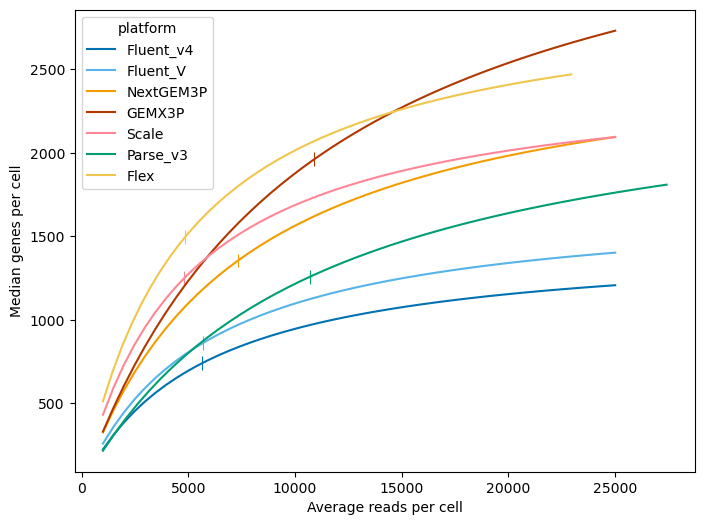

In [110]:
fig, ax = plt.subplots(figsize=(8, 6))
plot1 = sns.lineplot(plotting_df_gene_mm, x='nreads', y='median_gene_counts', hue='platform', palette=color_palette)
sns.scatterplot(rd50_data_g.reset_index(), x='nreads', y='ngenes', hue='index', marker='|', s=100, palette=color_palette, legend=None)
plt.xlabel('Average reads per cell')
plt.ylabel('Median genes per cell')
plt.show()

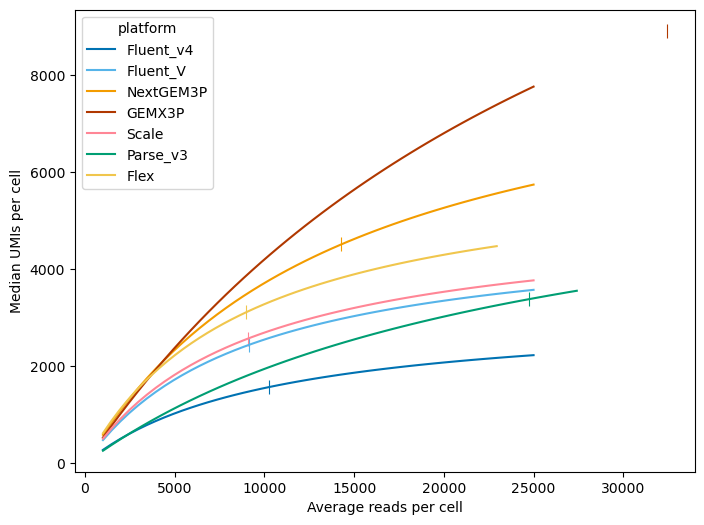

In [115]:
fig, ax = plt.subplots(figsize=(8, 6))
plot1 = sns.lineplot(plotting_df_umi_mm, x='nreads', y='median_umi_counts', hue='platform', palette=color_palette)
sns.scatterplot(rd50_data_u.reset_index(), x='nreads', y='numi', hue='index', marker='|', s=100, palette=color_palette, legend=None)
plt.xlabel('Average reads per cell')
plt.ylabel('Median UMIs per cell')
plt.show()

In [11]:
%matplotlib inline

In [104]:
plotting_df_gene_mm.head(n=20)

350

In [13]:
sns.lineplot(plotting_df_gene_mm, x='nreads', y='median_umi_counts', hue='platform')

<Axes: xlabel='nreads', ylabel='median_genes'>

In [114]:
rd50_data_u.head()

,nreads,numi
Fluent_v4,10232.733896,1572.793185
Fluent_V,9114.067697,2441.034124
NextGEM3P,14293.441132,4516.076407
GEMX3P,32415.040027,8917.011666
Scale,9057.513478,2570.097207


In [109]:
modeling_df_gene_mm.head(n=7)

,platform,max_val,RD50,max_val_sd,RD50_sd,RMSE,R-squared
0,Fluent_v4,1479.341746,5644.315769,47.365587,582.182623,73.171194,0.945724
1,Fluent_V,1720.655568,5678.654976,44.809367,477.859848,69.496052,0.961799
2,NextGEM3P,2710.432695,7332.770602,35.900140,273.746187,43.641523,0.993653
3,GEMX3P,3922.854886,10894.737681,41.886706,274.912156,35.976247,0.997717
4,Scale,2497.102566,4798.357355,74.001186,499.236537,130.625604,0.938978
5,Parse_v3,2515.986648,10700.767000,42.375614,392.920263,41.111125,0.992678
6,Flex,2992.931726,4852.676570,27.988997,150.095019,43.217257,0.995118
